# Year inclusive

**Goal:** I had done some other studies before trying to pretrain on the years and then predict them together, but Michael had suggested instead. 

**How do I think this might help?** Right now, it seems like the deep ensembles error that I estimate might be sufficient to cover a non-closure systematic, so I'm going to try...

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

import os
os.sys.path += ['../gp-for-flows/','../PyATLASstyle/','../../hh4b/hh4b-plots/'] 

from bkgPred import *
from flows import *

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

In [2]:
nSeeds = 25

config ='val1p1' 

fc = f'../gp-for-flows/configs/{config}.json'
with open(fc,'r') as cfile:
    hps = json.load(cfile)

L,H,nb,K,lr,beta,p = hps['L'],hps['H'],hps['nb'],hps['K'],hps['lr'],hps['beta'],hps['p']

modelDir = f'../gp-for-flows/models/'

colTag = '_'.join(hps['cols'])

modelConfig  = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'

In [3]:
x,y = 124,117
eps = 0.05
r_CR = 45

nSplits = 100
replica = 0

In [4]:
subDir16 = f'data16-MAY21_2b_{replica}of{nSplits}_detaCut_ggf'
subDir17 = f'data17-MAY21_2b_{replica}of{nSplits}_detaCut_ggf'
subDir18 = f'data18-MAY21_2b_{replica}of{nSplits}_detaCut_ggf'

In [5]:
h16,h17,h18 = {},{},{} # exclusive trainings
i16,i17,i18 = {},{},{} # exclusive trainings
d16,d17,d18 = {},{},{} # data histograms

'''
The exclusive traiigs
'''
tag = 'hists_gp_100k_25bins'
with open(f'{modelDir}/{subDir16}/{modelConfig}/{tag}.json','r') as hfile:
    out16 = json.load(hfile)
with open(f'{modelDir}/{subDir17}/{modelConfig}/{tag}.json','r') as hfile:
    out17 = json.load(hfile)
with open(f'{modelDir}/{subDir18}/{modelConfig}/{tag}.json','r') as hfile:
    out18 = json.load(hfile)

'''
The year inclusive traiigs
'''
subDirAll = subDir16.replace("16","161718")
tag = 'hists_gp_100k_'
with open(f'{modelDir}/{subDirAll}/{modelConfig}/{tag}16.json','r') as hfile:
    in16 = json.load(hfile)
with open(f'{modelDir}/{subDirAll}/{modelConfig}/{tag}17.json','r') as hfile:
    in17 = json.load(hfile)
with open(f'{modelDir}/{subDirAll}/{modelConfig}/{tag}18.json','r') as hfile:
    in18 = json.load(hfile)    
    
    
'''
The data histograms
'''
tag = 'dat__Xwt_cut'
with open(f'{modelDir}/{subDir16}/{tag}.json','r') as hfile:
    dat16 = json.load(hfile)
with open(f'{modelDir}/{subDir17}/{tag}.json','r') as hfile:
    dat17 = json.load(hfile)
with open(f'{modelDir}/{subDir18}/{tag}.json','r') as hfile:
    dat18 = json.load(hfile)
    
for k in out16.keys(): 
    if ('SR' in k) and ('Cos' not in k):
        h16[k] = np.array( out16[k])
        h17[k] = np.array( out17[k])
        h18[k] = np.array( out18[k])
        
        i16[k] = np.array( in16[k])
        i17[k] = np.array( in17[k])
        i18[k] = np.array( in18[k])
        
for k in dat16.keys():
    if 'SR' in k:
        d16[k] = np.array(dat16[k])
        d17[k] = np.array(dat17[k])
        d18[k] = np.array(dat18[k])
        

In [6]:
data_files = ['../data/RR/cryptotuples/data16.root', 
              '../data/RR/cryptotuples/data17.root', 
              '../data/RR/cryptotuples/data18.root']

In [7]:
# d = data(['../data/RR/cryptotuples/data17.root'],x,y,eps,r_CR,ntag=2,nSplits=nSplits,replica=replica)

In [26]:
for subDir in  [subDir16,subDir17,subDir18,subDirAll]:
    figDir = f'figures/{subDir}/trainYrComb'
    
    if not os.path.exists(figDir):
        os.mkdir(figDir)

<ipython-input-17-e8bf537bd1da>:15: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(range(len(h_2b)),1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


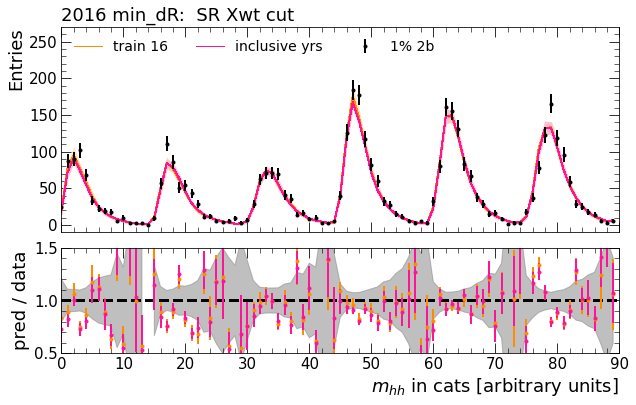

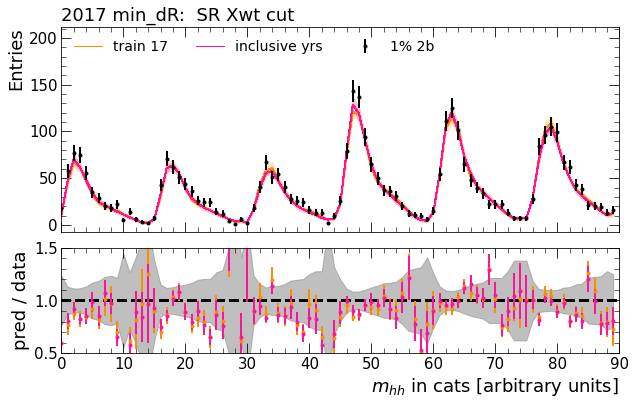

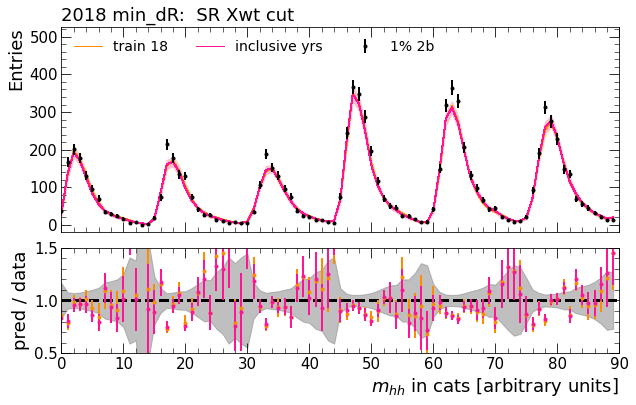

In [17]:
tag = '_SR_Xwt_cut'

for yr, hdict, idict, ddict, subDir in zip([16,17,18], [h16,h17,h18], [i16,i17,i18],
                                           [d16,d17,d18], [subDir16,subDir17,subDir18]):
    
    fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                                  gridspec_kw={"height_ratios": [.66,.34],
                                               "hspace":.1})

    h_2b = ddict[f'X_hh_dEta_hh_m_hh{tag}']
    xx = np.arange(len(h_2b))
    ax1.errorbar(xx,h_2b,np.sqrt(h_2b),color='k',lw=0, 
                 elinewidth=2,marker='.',label='1% 2b',zorder=5)

    ax2.fill_between(range(len(h_2b)),1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)

    ax2.plot([0,90],[1]*2,'k--')

    for hd,c0,c1,label in zip([hdict,idict],
                              ['bisque','pink'],
                              ['darkorange','deeppink'],
                              [f'train {yr}','inclusive yrs']):
    
        nom = hd[f'X_hh_dEta_hh_m_hh{tag}_mean']
        std = hd[f'X_hh_dEta_hh_m_hh{tag}_std']
        
        ax1.fill_between(range(len(nom)),nom+std,nom-std,color=c0)
        ax1.plot(nom,color=c1,label=label,lw=1)           

        ax2.errorbar(xx[h_2b!=0],
                     nom[h_2b!=0]/h_2b[h_2b!=0],
                     std[h_2b!=0]/h_2b[h_2b!=0],
                     color=c1,marker='.',lw=0,elinewidth=2)           
  
        
    ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
    ax2.set_ylabel('pred / data',fontsize=18)

    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title(f'20{yr} min_dR: '+tag.replace('_',' '),loc='left')

    ax1.legend(ncol=3,loc='upper left')
    ax1.set_xlim(0,90)
    ymin,ymax=ax1.get_ylim()
    ax1.set_ylim(ymin,1.3*ymax)

    ax2.set_ylim([0.5,1.5])

    plt.savefig(f'figures/{subDir}/trainYrComb/m_hh_cats{tag}.pdf',bbox_inches='tight')
    plt.show()

Ok! Separately, this looks _pretty great_ :)

I think the next step is to evaluate them all together.

In [20]:
dAll = {}
for k in d16.keys():
    dAll[k] = np.vstack([ddict[k] for ddict in [d16,d17,d18]]).sum(axis=0)

In [21]:
hAll = {}
iAll = {}

for k in h16.keys():
    if 'std' in k: 
        continue
        
    hAll[k] = np.vstack([hd[k] for hd in [h16,h17,h18]]).sum(axis=0)
    iAll[k] = np.vstack([hd[k] for hd in [i16,i17,i18]]).sum(axis=0)

In [22]:
for c, tag in product(myVars+['X_hh_dEta_hh_m_hh'],['','_Xwt_cut']):
    
    k = f'{c}_SR{tag}'
    
    # Consider the exclusive trainings uncorrelated
    hAll[f"{k}_std"] = np.sqrt(h16[f"{k}_std"]**2 + h17[f"{k}_std"]**2 + h18[f"{k}_std"]**2)
    
    # Correlated errors
    stack = np.vstack([iAll[f'{k}_{i}'] for i in range(nSeeds)])
    iAll[f"{k}_std"] = np.std(stack, axis=0)
        

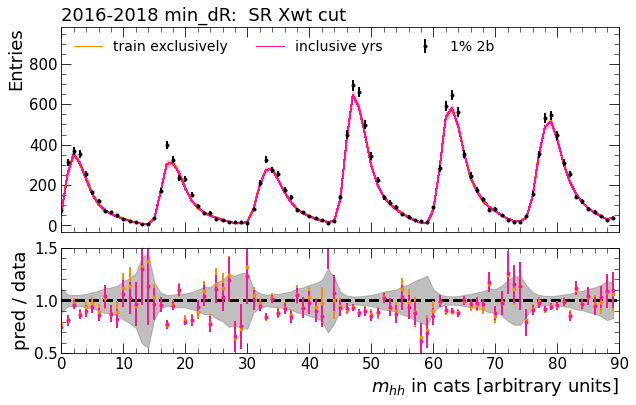

In [27]:
tag = '_SR_Xwt_cut'

fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":.1})

h_2b = dAll[f'X_hh_dEta_hh_m_hh{tag}']
xx = np.arange(len(h_2b))
ax1.errorbar(xx,h_2b,np.sqrt(h_2b),color='k',lw=0, 
             elinewidth=2,marker='.',label='1% 2b',zorder=5)

ax2.fill_between(range(len(h_2b)),1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)

ax2.plot([0,90],[1]*2,'k--')

for hd,c0,c1,label in zip([hAll,iAll],
                          ['bisque','pink'],
                          ['darkorange','deeppink'],
                          [f'train exclusively','inclusive yrs']):

    nom = hd[f'X_hh_dEta_hh_m_hh{tag}_mean']
    std = hd[f'X_hh_dEta_hh_m_hh{tag}_std']

    ax1.fill_between(range(len(nom)),nom+std,nom-std,color=c0)
    ax1.plot(nom,color=c1,label=label,lw=1)           

    ax2.errorbar(xx[h_2b!=0],
                 nom[h_2b!=0]/h_2b[h_2b!=0],
                 std[h_2b!=0]/h_2b[h_2b!=0],
                 color=c1,marker='.',lw=0,elinewidth=2)           


ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
ax2.set_ylabel('pred / data',fontsize=18)

ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
ax1.set_title(f'2016-2018 min_dR: '+tag.replace('_',' '),loc='left')

ax1.legend(ncol=3,loc='upper left')
ax1.set_xlim(0,90)
ymin,ymax=ax1.get_ylim()
ax1.set_ylim(ymin,1.3*ymax)

ax2.set_ylim([0.5,1.5])

plt.savefig(f'figures/{subDirAll}/trainYrComb/m_hh_cats{tag}.pdf',bbox_inches='tight')
    

plt.show()

Ooooh - while I'm at it, let's look at the `X_wt_tag` histograms!

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


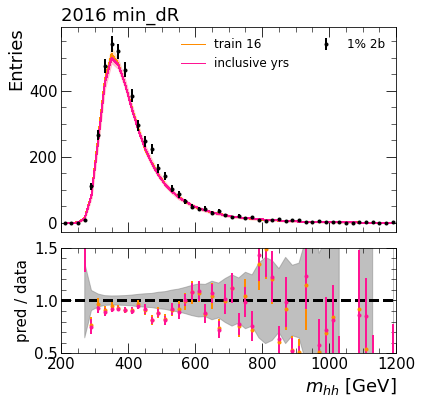

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


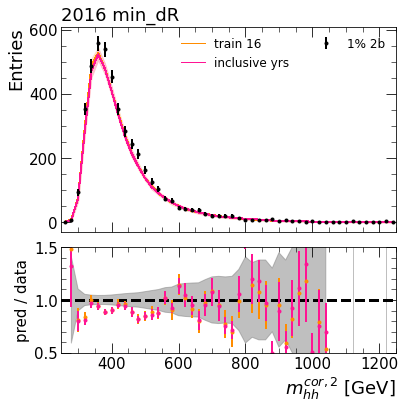

(55,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


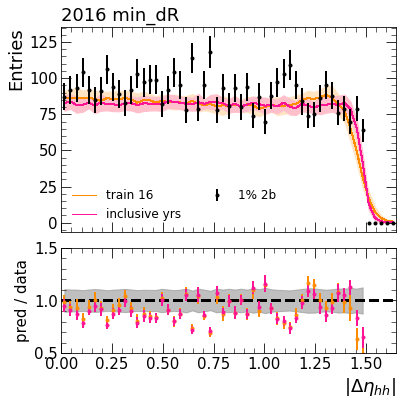

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


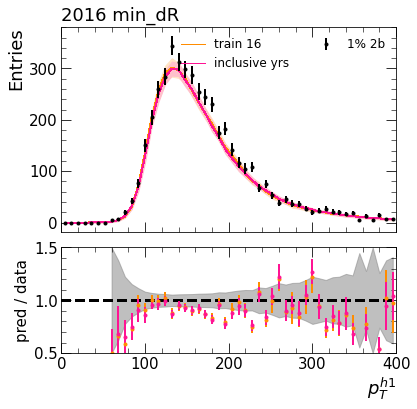

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


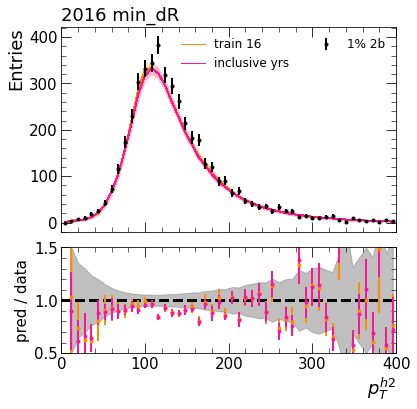

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


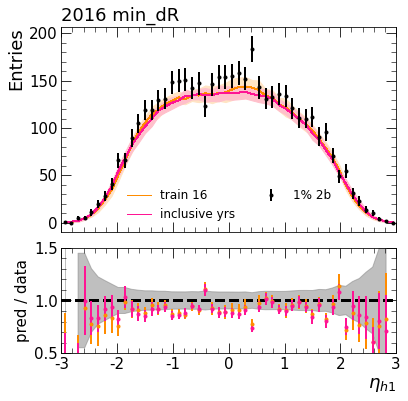

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


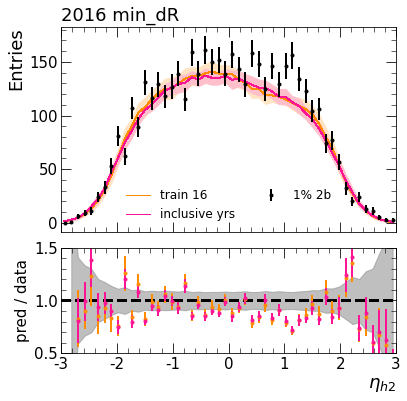

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


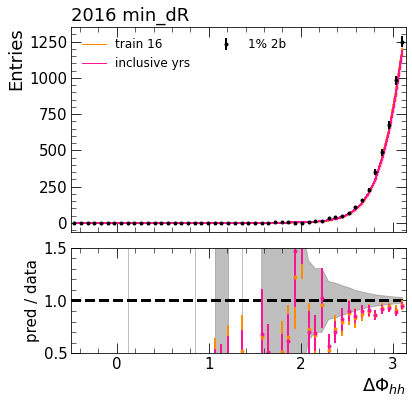

(50,)


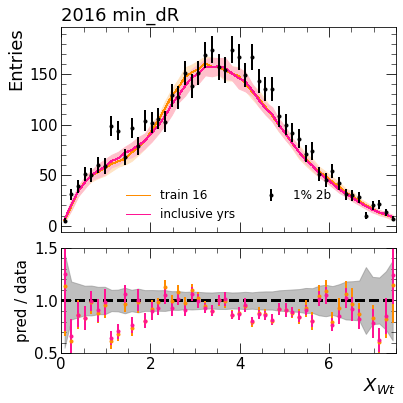

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


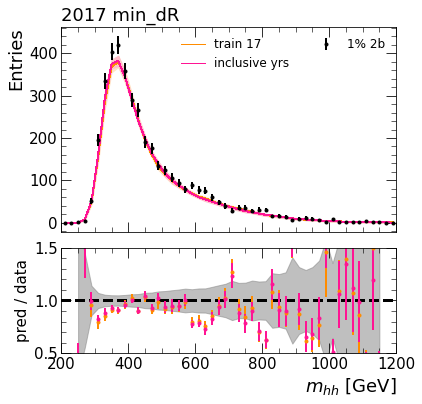

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


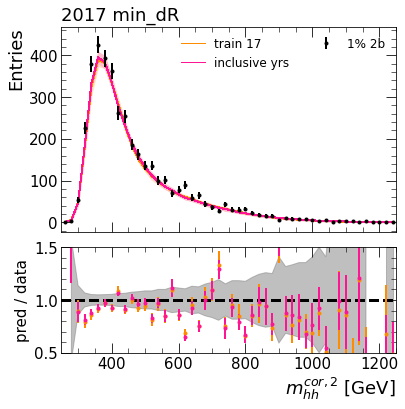

(55,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


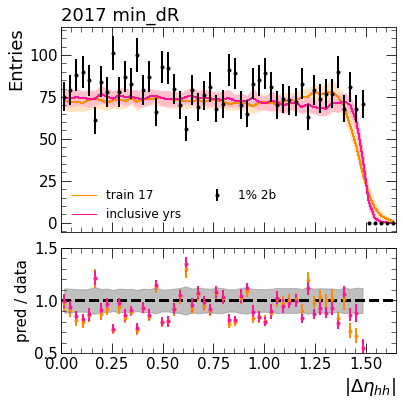

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


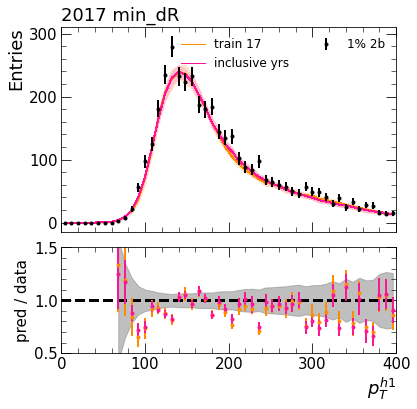

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


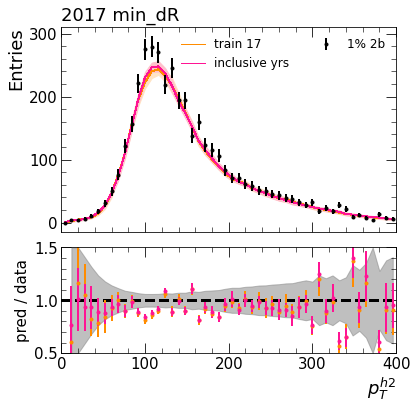

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


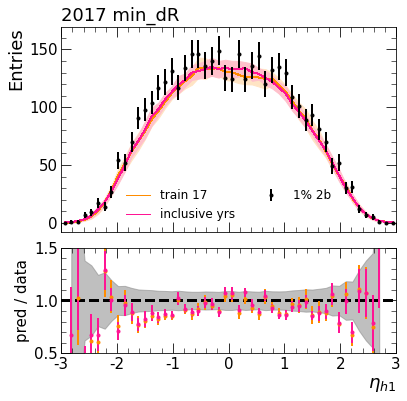

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


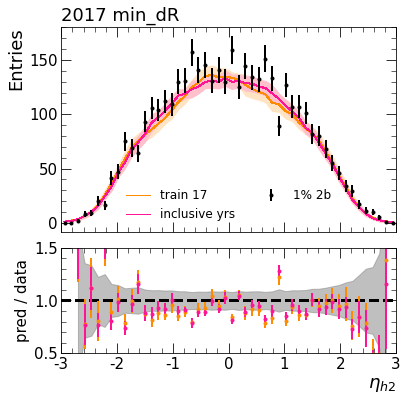

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


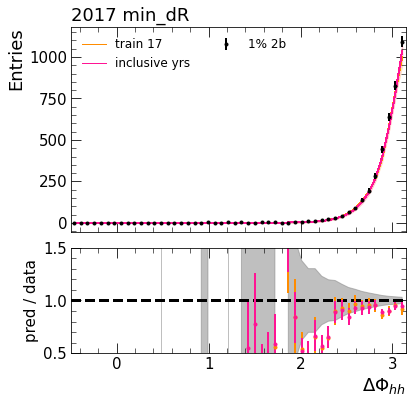

(50,)


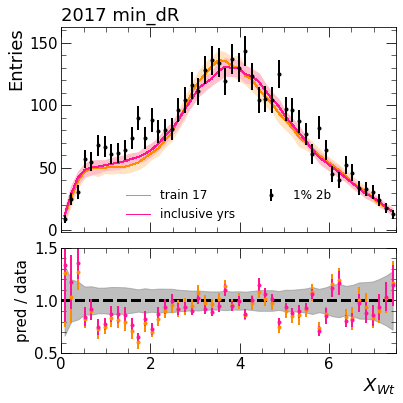

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


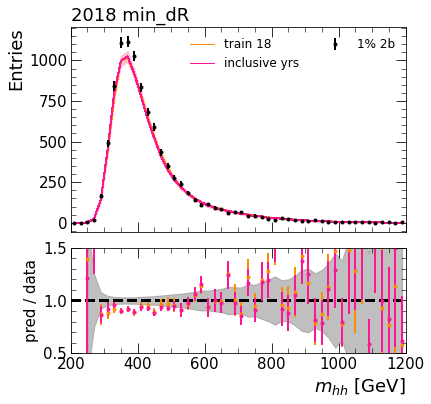

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


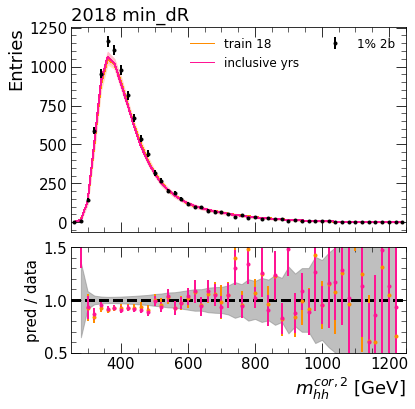

(55,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


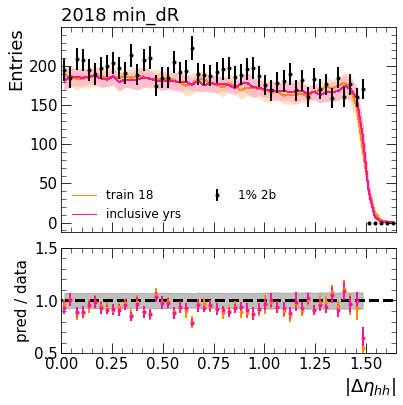

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


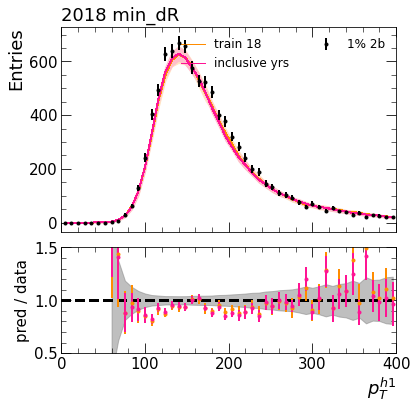

(50,)


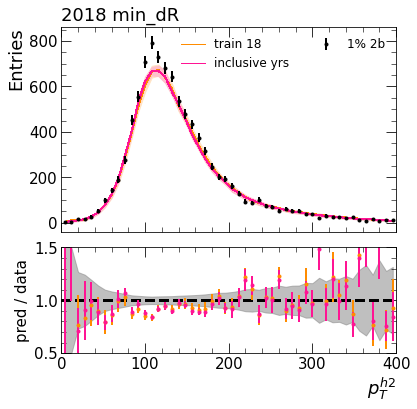

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


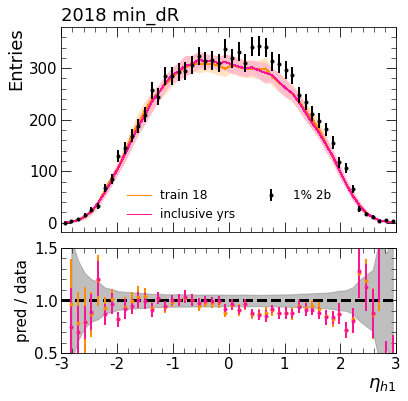

(50,)


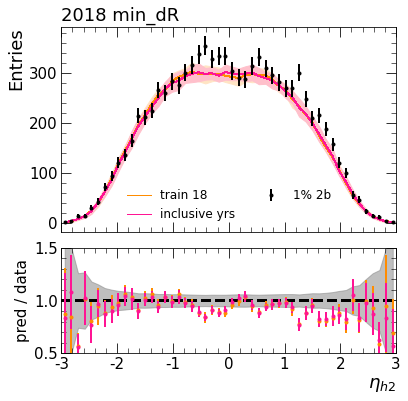

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


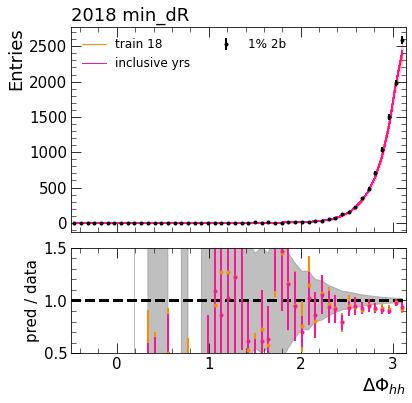

(50,)


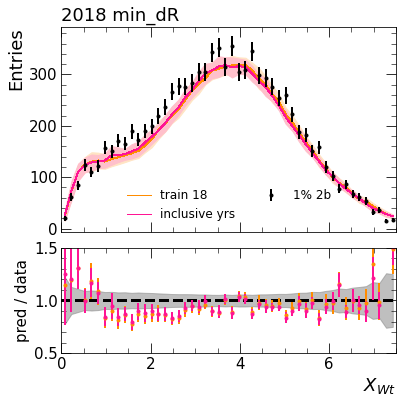

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


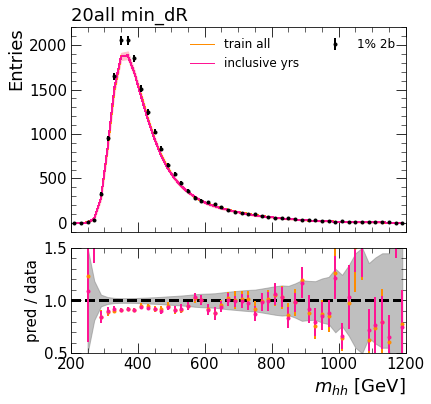

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


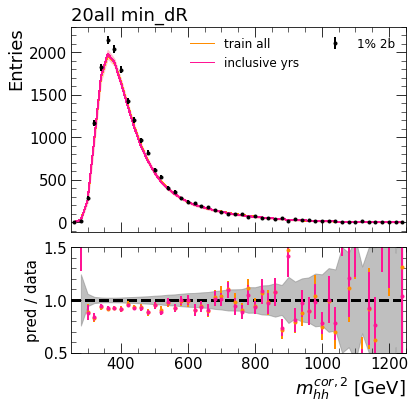

(55,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


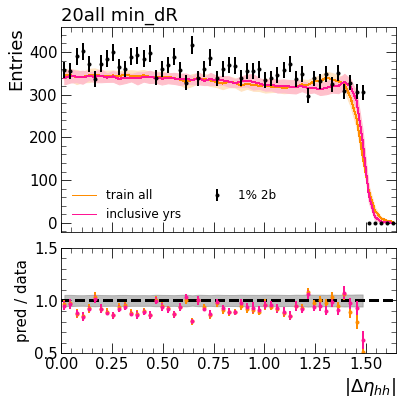

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


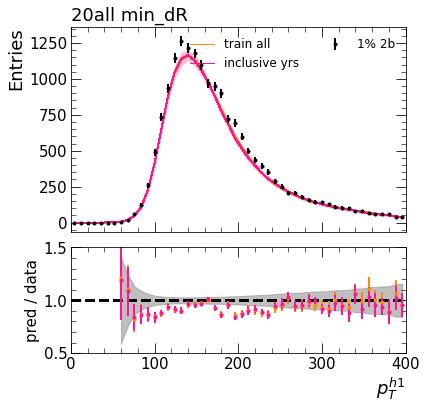

(50,)


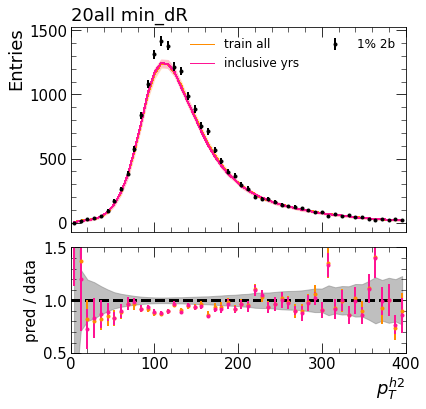

(50,)


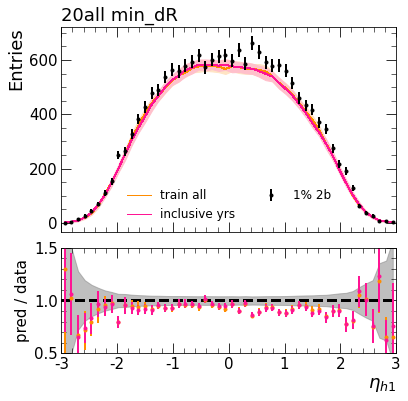

(50,)


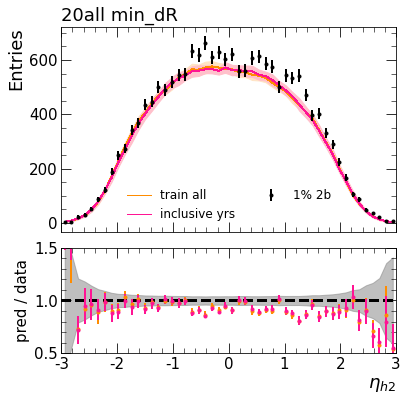

(50,)


<ipython-input-113-8cf22e85579f>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)


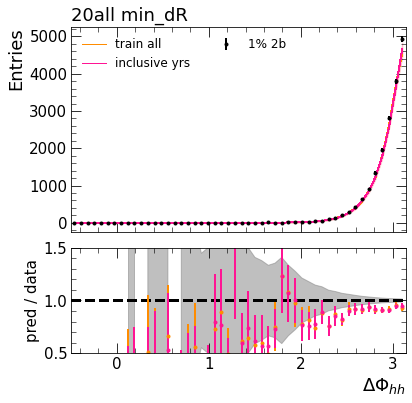

(50,)


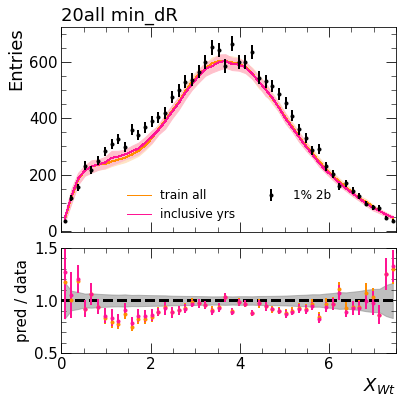

In [113]:
tag = '_SR'

for yr, hdict,idict,ddict in zip([16,17,18,'all'],
                                 [h16,h17,h18,hAll],
                                 [i16,i17,i18,iAll],
                                 [d16,d17,d18,dAll]):

    for c, nb, r, xl in zip(myVars, bis, myRanges, varLabels):

        fig, (ax1,ax2) = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                                  gridspec_kw={"height_ratios": [.66,.34],
                                               "hspace":.1})

        e = np.linspace(*r,nb+1)
        xx = 0.5 * (e[1:] + e[:-1])

        h_2b = ddict[f'{c}{tag}']
        print(h_2b.shape)
        ax1.errorbar(xx,h_2b,np.sqrt(h_2b),color='k',lw=0, 
                     elinewidth=2,marker='.',label='1% 2b',zorder=5)

        ax2.fill_between(xx,1+1/np.sqrt(h_2b),1-1/np.sqrt(h_2b),color='grey',alpha=.5,zorder=0)

        ax2.plot(e[[0,-1]],[1]*2,'k--')

        for hd,c0,c1,label in zip([hdict,idict],
                                  ['bisque','pink'],
                                  ['darkorange','deeppink'],
                                  ['train exclusive' if yr=='all' else f'train {yr}','inclusive yrs']):

            nom = hd[f'{c}{tag}_mean']
            std = hd[f'{c}{tag}_std']

            ax1.fill_between(xx,nom+std,nom-std,color=c0)
            ax1.plot(xx,nom,color=c1,label=label,lw=1)           

            ax2.errorbar(xx[h_2b!=0],
                         nom[h_2b!=0]/h_2b[h_2b!=0],
                         std[h_2b!=0]/h_2b[h_2b!=0],
                         color=c1,marker='.',lw=0,elinewidth=2)           

        ax2.set_xlabel(xl,x=1,ha='right',fontsize=18)
        ax2.set_ylabel('pred / data')
        ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
        if yr == 'all':
            ax1.set_title(f'20{yr} min_dR',x=0,loc='left')
        else:
            ax1.set_title(f'2016-2018 min_dR',x=0,loc='left')
            
        ax1.legend(ncol=2,fontsize=12)
        ax1.set_xlim(e[[0,-1]])
        ax2.set_ylim(0.5,1.5)

        plt.savefig(f'figures/{subDir}/{c}_{tag}.pdf',bbox_inches='tight')
        plt.show()

In [34]:
none 

0.15

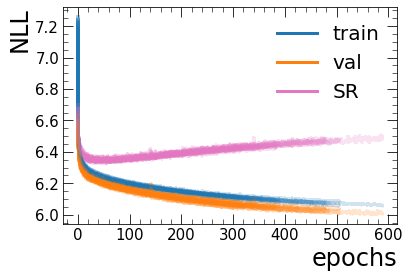

In [69]:
plt.figure()
plt.xlabel('epochs',loc='right',fontsize=24)
plt.ylabel('NLL',loc='top',fontsize=24)


for seed in range(nSeeds):
    
    try:
        with open(f'{modelDir}/{subDirAll}/{modelConfig}/loss_acc_seed{seed}.json','r') as f:
            out = json.load(f)
    except:
        print(f'seed {seed} not finished yet')

    for k,c in zip(['train','val','SR'],['C0','C1','C6']):
        plt.plot(out[f'{k}_loss'],color=c,alpha=.2)

for k,c in zip(['train','val','SR'],['C0','C1','C6']):
    plt.plot([],label=k,color=c)

plt.legend(fontsize=20)

plt.show()